Loaded 948 chess games between 35 players

Note the disconnected component consisting of:
['Caruana, Fabiano', 'Timman, Jan H', 'Korchnoi, Viktor L', 'Anand,V', 'Karpov, Anatoly', 'Kasparov, Gary', 'Carlsen, Magnus', 'Kamsky, Gata', 'Topalov,V', 'Leko,P', 'Gelfand,B', 'Karjakin, Sergey', 'Kramnik,V']


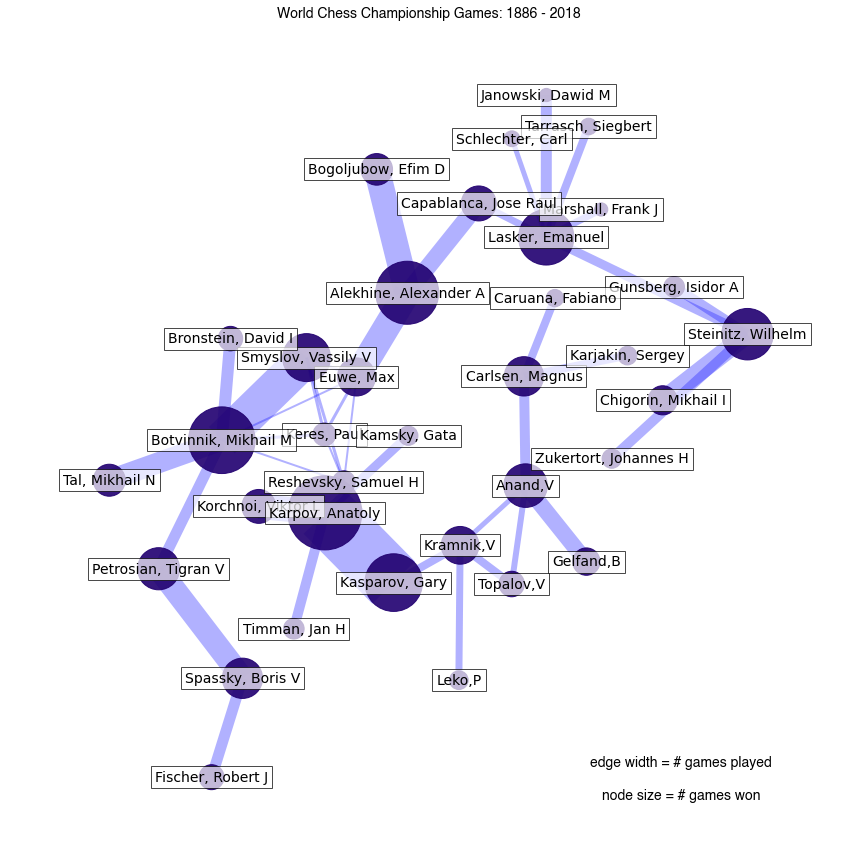

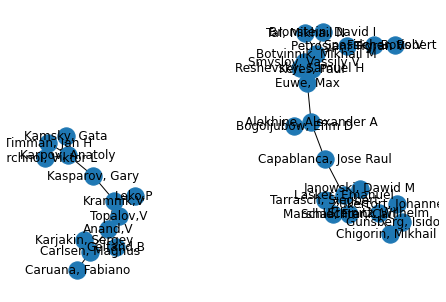

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# tag names specifying what game info should be
# stored in the dict on each digraph edge
game_details = ["Event", "Date", "Result", "Site"]


def chess_pgn_graph(pgn_file="WCCFinal1.pgn.bz2"):
    """Read chess games in pgn format in pgn_file.

    Filenames ending in .bz2 will be uncompressed.

    Return the MultiDiGraph of players connected by a chess game.
    Edges contain game data in a dict.

    """
    import bz2

    G = nx.MultiDiGraph()
    game = {}
    with bz2.BZ2File(pgn_file) as datafile:
        lines = [line.decode().rstrip("\r\n") for line in datafile]
    for line in lines:
        if line.startswith("["):
            tag, value = line[1:-1].split(" ", 1)
            game[str(tag)] = value.strip('"')
        else:
            # empty line after tag set indicates
            # we finished reading game info
            if game:
                white = game.pop("White")
                black = game.pop("Black")
                G.add_edge(white, black, **game)
                game = {}
    return G


G = chess_pgn_graph()

print(
    f"Loaded {G.number_of_edges()} chess games between {G.number_of_nodes()} players\n"
)

# identify connected components of the undirected version
H = G.to_undirected()
Gcc = [H.subgraph(c) for c in nx.connected_components(H)]
if len(Gcc) > 1:
    print(f"Note the disconnected component consisting of:\n{Gcc[1].nodes()}")

# make new undirected graph H without multi-edges
H = nx.Graph(G)

# edge width is proportional number of games played
edgewidth = [len(G.get_edge_data(u, v)) for u, v in H.edges()]

# node size is proportional to number of games won
wins = dict.fromkeys(G.nodes(), 0.0)
for (u, v, d) in G.edges(data=True):
    r = d["Result"].split("-")
    if r[0] == "1":
        wins[u] += 1.0
    elif r[0] == "1/2":
        wins[u] += 0.5
        wins[v] += 0.5
    else:
        wins[v] += 1.0
nodesize = [wins[v] * 50 for v in H]

# Generate layout for visualization
pos = nx.kamada_kawai_layout(H)
pos["Steinitz, Wilhelm"] += (0.6, 0.0)
pos["Caruana, Fabiano"] += (0, -0.1)
pos["Capablanca, Jose Raul"] += (0.0, 0.2)
pos["Kasparov, Gary"] += (0.0, -0.15)
pos["Carlsen, Magnus"] += (-0.15, 0)
pos["Kamsky, Gata"] += (0.45, -0.1)
pos["Tal, Mikhail N"] += (-0.45, -0.1)
pos["Botvinnik, Mikhail M"] += (-0.25, 0)
pos["Petrosian, Tigran V"] += (-0.45,0)

fig, ax = plt.subplots(figsize=(12, 12))
# Visualize graph components
nx.draw_networkx_edges(H, pos, alpha=0.3, width=edgewidth, edge_color="b")
nx.draw_networkx_nodes(H, pos, node_size=nodesize, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(H, pos, font_size=14, bbox=label_options)

# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("World Chess Championship Games: 1886 - 2018", font)
# Change font color for legend
#font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "edge width = # games played",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = # games won",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

nx.draw(H, with_labels=True)

In [7]:
#we will write a function that takes a graph, computes different centrality measures, and returns a dataframe with
#the results
import pandas as pd
def get_centrality_scores(aGraph):
    df = pd.DataFrame()
    deg_cent = nx.degree_centrality(aGraph)
    closeness_cent = nx.closeness_centrality(aGraph)
    eig_cent = nx.eigenvector_centrality(aGraph)
    betweenness_cent = nx.betweenness_centrality(aGraph)
    #let us also get the number of triangles
    triangles = nx.triangles(aGraph)
    #finally, we will get the clustering coefficient -- that is, how redunant are node's connections
    clustering_coeff = nx.clustering(aGraph)
    #now populate the dataframe
    df['Nodes'] = list(deg_cent.keys())
    df['Degree_Centrality'] = list(deg_cent.values())
    df['Eigenvector_Centrality'] = list(eig_cent.values())
    df['Betweenness_Centrality'] = list(betweenness_cent.values())
    df['Triangles'] = list(triangles.values())
    df['Clustering_Coefficient'] = list(clustering_coeff.values())
    return df

In [11]:
data = get_centrality_scores(H).sort_values(by = ['Degree_Centrality','Eigenvector_Centrality','Betweenness_Centrality'],ascending = False)
data

,Nodes,Degree_Centrality,Eigenvector_Centrality,Betweenness_Centrality,Triangles,Clustering_Coefficient
16,"Botvinnik, Mikhail M",0.205882,4.826002e-01,0.155080,6,0.285714
4,"Lasker, Emanuel",0.176471,1.017556e-02,0.224599,0,0.000000
12,"Euwe, Max",0.147059,4.379384e-01,0.192513,6,0.600000
13,"Keres, Paul",0.117647,4.153765e-01,0.000000,6,1.000000
14,"Smyslov, Vassily V",0.117647,4.153765e-01,0.000000,6,1.000000
15,"Reshevsky, Samuel H",0.117647,4.153765e-01,0.000000,6,1.000000
1,"Steinitz, Wilhelm",0.117647,2.905993e-03,0.101604,0,0.000000
30,"Anand,V",0.117647,6.112384e-06,0.062389,1,0.166667
27,"Kramnik,V",0.117647,6.058192e-06,0.073084,1,0.166667
23,"Karpov, Anatoly",0.117647,2.015431e-06,0.053476,0,0.000000


In [12]:
average_degree_centrality = sum(data['Degree_Centrality'].tolist()) / data.shape[0]
average_degree_centrality


0.06722689075630248

Text(0.5, 1.0, 'World Chess Champions: Node Degree')

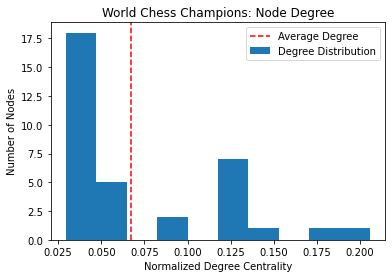

In [13]:
import matplotlib.pyplot as plt
plt.hist(data['Degree_Centrality'].tolist(),label='Degree Distribution')
plt.axvline(average_degree_centrality,color='r',linestyle='dashed',label='Average Degree')
plt.legend()
plt.xlabel('Normalized Degree Centrality')
plt.ylabel('Number of Nodes')
plt.title('World Chess Champions: Node Degree')

In [14]:
cliques = nx.find_cliques(H)
list(cliques)

[['Timman, Jan H', 'Karpov, Anatoly'],
 ['Botvinnik, Mikhail M', 'Tal, Mikhail N'],
 ['Botvinnik, Mikhail M',
  'Smyslov, Vassily V',
  'Reshevsky, Samuel H',
  'Euwe, Max',
  'Keres, Paul'],
 ['Botvinnik, Mikhail M', 'Bronstein, David I'],
 ['Botvinnik, Mikhail M', 'Petrosian, Tigran V'],
 ['Alekhine, Alexander A', 'Bogoljubow, Efim D'],
 ['Alekhine, Alexander A', 'Euwe, Max'],
 ['Alekhine, Alexander A', 'Capablanca, Jose Raul'],
 ['Anand,V', 'Gelfand,B'],
 ['Anand,V', 'Kramnik,V', 'Topalov,V'],
 ['Anand,V', 'Carlsen, Magnus'],
 ['Steinitz, Wilhelm', 'Gunsberg, Isidor A'],
 ['Steinitz, Wilhelm', 'Zukertort, Johannes H'],
 ['Steinitz, Wilhelm', 'Lasker, Emanuel'],
 ['Steinitz, Wilhelm', 'Chigorin, Mikhail I'],
 ['Kamsky, Gata', 'Karpov, Anatoly'],
 ['Lasker, Emanuel', 'Capablanca, Jose Raul'],
 ['Lasker, Emanuel', 'Tarrasch, Siegbert'],
 ['Lasker, Emanuel', 'Marshall, Frank J'],
 ['Lasker, Emanuel', 'Janowski, Dawid M'],
 ['Lasker, Emanuel', 'Schlechter, Carl'],
 ['Spassky, Boris V', '

In [15]:
#what is the maximal clique among the cliques
cliques = nx.find_cliques(H)
maximal_clique = max(list(cliques), key = len)

In [13]:
maximal_clique

['Botvinnik, Mikhail M',
 'Keres, Paul',
 'Euwe, Max',
 'Reshevsky, Samuel H',
 'Smyslov, Vassily V']

In [16]:
maximal_clique

['Botvinnik, Mikhail M',
 'Smyslov, Vassily V',
 'Reshevsky, Samuel H',
 'Euwe, Max',
 'Keres, Paul']

In [17]:
list(nx.degree(G))

[('Zukertort, Johannes H', 20),
 ('Steinitz, Wilhelm', 98),
 ('Chigorin, Mikhail I', 40),
 ('Gunsberg, Isidor A', 19),
 ('Lasker, Emanuel', 95),
 ('Marshall, Frank J', 15),
 ('Tarrasch, Siegbert', 16),
 ('Janowski, Dawid M', 21),
 ('Schlechter, Carl', 10),
 ('Capablanca, Jose Raul', 48),
 ('Alekhine, Alexander A', 140),
 ('Bogoljubow, Efim D', 51),
 ('Euwe, Max', 75),
 ('Keres, Paul', 19),
 ('Smyslov, Vassily V', 88),
 ('Reshevsky, Samuel H', 20),
 ('Botvinnik, Mikhail M', 175),
 ('Bronstein, David I', 24),
 ('Tal, Mikhail N', 42),
 ('Petrosian, Tigran V', 69),
 ('Spassky, Boris V', 68),
 ('Fischer, Robert J', 21),
 ('Korchnoi, Viktor L', 50),
 ('Karpov, Anatoly', 209),
 ('Kasparov, Gary', 135),
 ('Timman, Jan H', 21),
 ('Kamsky, Gata', 18),
 ('Kramnik,V', 56),
 ('Leko,P', 14),
 ('Topalov,V', 28),
 ('Anand,V', 76),
 ('Gelfand,B', 32),
 ('Carlsen, Magnus', 52),
 ('Karjakin, Sergey', 16),
 ('Caruana, Fabiano', 15)]

In [18]:
#let us examine k-cores -- nodes that have a degree of at least k
k_core_2 = nx.k_core(H, 2)
list(k_core_2)

['Botvinnik, Mikhail M',
 'Anand,V',
 'Smyslov, Vassily V',
 'Topalov,V',
 'Keres, Paul',
 'Reshevsky, Samuel H',
 'Euwe, Max',
 'Kramnik,V']

In [16]:
from networkx.algorithms.community import k_clique_communities
list(k_clique_communities(H, 3))

[frozenset({'Anand,V', 'Kramnik,V', 'Topalov,V'}),
 frozenset({'Botvinnik, Mikhail M',
            'Euwe, Max',
            'Keres, Paul',
            'Reshevsky, Samuel H',
            'Smyslov, Vassily V'})]

In [19]:
#let us try other paritioning/community detection algorithms
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, girvan_newman

In [20]:
greedy = greedy_modularity_communities(H)
list(greedy)

[frozenset({'Alekhine, Alexander A',
            'Bogoljubow, Efim D',
            'Capablanca, Jose Raul',
            'Janowski, Dawid M',
            'Lasker, Emanuel',
            'Marshall, Frank J',
            'Schlechter, Carl',
            'Tarrasch, Siegbert'}),
 frozenset({'Anand,V',
            'Carlsen, Magnus',
            'Caruana, Fabiano',
            'Gelfand,B',
            'Karjakin, Sergey',
            'Kramnik,V',
            'Leko,P',
            'Topalov,V'}),
 frozenset({'Botvinnik, Mikhail M',
            'Bronstein, David I',
            'Euwe, Max',
            'Keres, Paul',
            'Reshevsky, Samuel H',
            'Smyslov, Vassily V',
            'Tal, Mikhail N'}),
 frozenset({'Kamsky, Gata',
            'Karpov, Anatoly',
            'Kasparov, Gary',
            'Korchnoi, Viktor L',
            'Timman, Jan H'}),
 frozenset({'Chigorin, Mikhail I',
            'Gunsberg, Isidor A',
            'Steinitz, Wilhelm',
            'Zukertort, Johanne

In [21]:
#How good is the partitioning? Use modularity
from networkx.algorithms.community import modularity
modularity(H, greedy)

0.685

In [22]:
#let us try label_propagation_communities
label = label_propagation_communities(H)
list(label)

[{'Chigorin, Mikhail I',
  'Gunsberg, Isidor A',
  'Steinitz, Wilhelm',
  'Zukertort, Johannes H'},
 {'Capablanca, Jose Raul',
  'Janowski, Dawid M',
  'Lasker, Emanuel',
  'Marshall, Frank J',
  'Schlechter, Carl',
  'Tarrasch, Siegbert'},
 {'Alekhine, Alexander A', 'Bogoljubow, Efim D'},
 {'Botvinnik, Mikhail M',
  'Bronstein, David I',
  'Euwe, Max',
  'Keres, Paul',
  'Petrosian, Tigran V',
  'Reshevsky, Samuel H',
  'Smyslov, Vassily V',
  'Tal, Mikhail N'},
 {'Fischer, Robert J', 'Spassky, Boris V'},
 {'Kamsky, Gata', 'Karpov, Anatoly', 'Korchnoi, Viktor L', 'Timman, Jan H'},
 {'Anand,V',
  'Gelfand,B',
  'Kasparov, Gary',
  'Kramnik,V',
  'Leko,P',
  'Topalov,V'},
 {'Carlsen, Magnus', 'Caruana, Fabiano', 'Karjakin, Sergey'}]

In [23]:
modularity(H, label_propagation_communities(H))

0.6512500000000001

In [24]:
g_newman = girvan_newman(H)

In [25]:
node_groups = []
for com in next(g_newman):
  node_groups.append(list(com))

In [25]:
node_groups = []
for com in next(g_newman):
  node_groups.append(list(com))


In [26]:
node_groups

[['Capablanca, Jose Raul',
  'Tarrasch, Siegbert',
  'Chigorin, Mikhail I',
  'Gunsberg, Isidor A',
  'Steinitz, Wilhelm',
  'Lasker, Emanuel',
  'Marshall, Frank J',
  'Zukertort, Johannes H',
  'Janowski, Dawid M',
  'Schlechter, Carl'],
 ['Fischer, Robert J',
  'Botvinnik, Mikhail M',
  'Spassky, Boris V',
  'Alekhine, Alexander A',
  'Petrosian, Tigran V',
  'Tal, Mikhail N',
  'Smyslov, Vassily V',
  'Keres, Paul',
  'Bronstein, David I',
  'Reshevsky, Samuel H',
  'Bogoljubow, Efim D',
  'Euwe, Max'],
 ['Caruana, Fabiano',
  'Timman, Jan H',
  'Korchnoi, Viktor L',
  'Anand,V',
  'Karpov, Anatoly',
  'Kasparov, Gary',
  'Carlsen, Magnus',
  'Kamsky, Gata',
  'Topalov,V',
  'Karjakin, Sergey',
  'Leko,P',
  'Gelfand,B',
  'Kramnik,V']]

In [27]:
modularity(H, node_groups)

0.6215625